In [1]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler



In [2]:
# Load the dataset into a DataFrame
# df = pd.read_csv('data/kc_house_data.csv')
df = pd.read_csv('data/updated_housing.csv')

Checking info, nulls

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29211 entries, 0 to 29210
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29211 non-null  int64  
 1   date           29211 non-null  object 
 2   price          29211 non-null  float64
 3   bedrooms       29211 non-null  int64  
 4   bathrooms      29211 non-null  float64
 5   sqft_living    29211 non-null  int64  
 6   sqft_lot       29211 non-null  int64  
 7   floors         29211 non-null  float64
 8   waterfront     29211 non-null  object 
 9   greenbelt      29211 non-null  object 
 10  nuisance       29211 non-null  object 
 11  view           29211 non-null  object 
 12  condition      29211 non-null  object 
 13  grade          29211 non-null  object 
 14  heat_source    29182 non-null  object 
 15  sewer_system   29198 non-null  object 
 16  sqft_above     29211 non-null  int64  
 17  sqft_basement  29211 non-null  int64  
 18  sqft_g

- 30155 long
- Several object dtypes
- heat_source and sewer_system have nulls

### Looking further into the null and duplicate values

In [4]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      29
sewer_system     13
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
geometry          0
MHHI1             0
traffic_de        0
toxic_rele        0
hazardou_2        0
SCHDST            0
NAME              0
DSTNUM            0
dtype: int64

In [5]:
# locating duplicates
print(f'Number of Duplicates: {df.duplicated().sum()}')
df.loc[df.duplicated() == True]

Number of Duplicates: 1


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,lat,long,geometry,MHHI1,traffic_de,toxic_rele,hazardou_2,SCHDST,NAME,DSTNUM
24338,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,...,47.68069,-122.172135,POINT (-122.172135 47.680690000000006),95625.0,6.0,3786.715617,2.0,414,Lake Washington,17414


### Function for droping duplicates, nulls, and other specified columns

In [6]:
def dropper(df, one=None, two=None, three=None):
    '''
    Input: DataFrame, request 1,request 2, request 3
    requests:
    'duplicates' to drop duplicates
    'nulls' to drop null values
    list containing df column names l = ['','','']
    '''
    request = [one,two,three]
    if 'duplicates' in request:
        df = df.drop_duplicates()
    if 'nulls' in request:
        df = df.dropna()
    for req in request:
        if isinstance(req, list):
            df = df.drop(columns=req, axis=1).reset_index(drop=True)
    return(df)

- below we drop duplicates and null values, in total there is only 1 duplicated row and 42 null values

In [7]:
droping =['id','geometry','address','NAME','DSTNUM','date','lat','long']
df_clean = dropper(df, 'duplicates', 'nulls', droping)

### Checking for Catagoricals

In [8]:
categoricals = df_clean.select_dtypes("object")

for col in categoricals:
    print(df_clean[col].value_counts(), "\n")

NO     28664
YES      506
Name: waterfront, dtype: int64 

NO     28401
YES      769
Name: greenbelt, dtype: int64 

NO     24166
YES     5004
Name: nuisance, dtype: int64 

NONE         25651
AVERAGE       1891
GOOD           868
EXCELLENT      545
FAIR           215
Name: view, dtype: int64 

Average      17581
Good          8046
Very Good     3258
Fair           224
Poor            61
Name: condition, dtype: int64 

7 Average        11547
8 Good            8852
9 Better          3587
6 Low Average     2848
10 Very Good      1347
11 Excellent       402
5 Fair             385
12 Luxury          122
4 Low               46
13 Mansion          24
3 Poor               9
2 Substandard        1
Name: grade, dtype: int64 

Gas                  20147
Electricity           5950
Oil                   2899
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64 

PUBLIC                24833
PRIVATE               

# converting to numeric types

In [9]:
def numeric_housing(df): 
    '''
    This function converts all boolean or rating types into numerics from input df. 
    this is saved as df_numeric
    This only works with housing data
    '''
    
    def convert_boolean(df,x=None):
        '''
        This function converts all boolean data into numeric types
        Used in numeric_df
        input dataframe
        '''
        boolean_cols = df.select_dtypes(include='object').columns
        column_name = []
        for col in boolean_cols:
            if set(df[col].unique()) == {'YES', 'NO'}:
                df[col] = df[col].replace({"NO": 0, "YES": 1})
                column_name.append(col)

        print(f'Boolean Conversions:{column_name}')
        return(df)

    df_numeric = df.copy()

    # Returns the new df_clean and lists the columns changed
    convert_boolean(df_numeric,1)

    # adjusting view column 
    # View has no intupretation written so it was self interpreted
#     df_numeric["view"] = df_numeric["view"].replace({"NONE": 0, "FAIR": 1, "AVERAGE": 2, "GOOD": 3, "EXCELLENT": 4,})

    # adjusting condition column 
    # View https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c 
    # under building condition it lists the order
    df_numeric["condition"] = df_numeric["condition"].replace({"Poor": 0, "Fair": 1, "Average": 2,
                                                               "Good": 3, "Very Good": 4,})
                                                
        
    # adjusting grade column 
    # View https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c 
    # under building grade it lists the order
    # they list the assosiated number with in name, i replaced it to just be the number
    df_numeric["grade"] = df_numeric["grade"].replace({"2 Substandard": 2,  "3 Poor": 3, "4 Low": 4, "5 Fair": 5,
                                                       "6 Low Average": 6, "7 Average": 7, "8 Good": 8, 
                                                       "9 Better": 9, "10 Very Good": 10, "11 Excellent": 11, 
                                                       "12 Luxury": 12, "13 Mansion": 13,})
                               
    df_numeric['renovated']= df_numeric['yr_renovated'].apply(lambda x: 1 if x !=0 else 0)
    df_numeric = df_numeric.drop(columns='yr_renovated')
    
    adjusted = ['view','condition', 'grade','date']
    
    print(f'Rating Conversions: {adjusted}')
#     print(display(df_numeric.head()))
    return(df_numeric)
df_clean = numeric_housing(df_clean)

Boolean Conversions:['waterfront', 'greenbelt', 'nuisance']
Rating Conversions: ['view', 'condition', 'grade', 'date']


# Creating Dummy variables

In [10]:
def for_dummies(df,columns):
    '''
    (dataframe, column name or list)
    creates a dummy variable for each specified column, 
    drops column with heighest value count
    columns: 'column' or ['column1','column2',...]
    '''
    if isinstance(columns, str):
        columns = [columns]
    for column in columns:
        if isinstance(df[column], object) == False:
            df[column] = df[column].astype(object)
        dropped = str(df[column].value_counts().idxmax())
        name_drop = column + '_' +dropped
        print(f'Dropped Column: {name_drop}')
        df_dum = pd.get_dummies(df, columns=[column], drop_first=False)
        df_dum = df_dum.drop(columns=name_drop)
        df = df_dum
    return(df)

In [11]:
dum_list = ['SCHDST','view', 'sewer_system']
df_clean = for_dummies(df_clean, dum_list)


Dropped Column: SCHDST_1
Dropped Column: view_NONE
Dropped Column: sewer_system_PUBLIC


In [12]:
df_clean

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,SCHDST_415,SCHDST_417,SCHDST_888,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC RESTRICTED
0,675000.0,4,1.0,1180,7140,1.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,728000.0,4,2.0,2170,7520,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,645000.0,3,2.0,1520,8250,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,760600.0,3,2.5,2570,2889,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,624950.0,3,2.5,1610,8625,1.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,380000.0,2,1.0,800,9927,1.5,0,0,1,2,...,0,0,0,0,0,0,0,1,0,0
29166,199000.0,2,1.0,1150,10098,1.5,0,0,1,2,...,0,0,0,1,0,0,0,1,0,0
29167,395000.0,1,1.0,620,10400,1.5,0,0,1,2,...,0,0,0,0,0,0,0,1,0,0
29168,328000.0,2,1.5,980,5000,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


# Dropping all left over object dtypes

In [13]:
df_object = df_clean.select_dtypes(include='object')
print(f'The following columns were dropped due to being object types\n{df_object.columns}')
df_clean = df_clean.drop(df_object,axis=1)

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


# Removing Outliers 

In [14]:
df_zscore = df_clean.apply(stats.zscore)
df_zscore

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,SCHDST_415,SCHDST_417,SCHDST_888,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC RESTRICTED
0,-0.488895,0.576730,-1.489927,-0.974068,-0.164133,-0.942031,-0.132864,-0.164549,-0.455047,0.724182,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,-0.417511,-0.013093,-0.008281
1,-0.429707,0.576730,-0.371840,0.039630,-0.157886,-0.942031,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,-0.417511,-0.013093,-0.008281
2,-0.522397,-0.447141,-0.371840,-0.625930,-0.145885,-0.942031,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,-0.417511,-0.013093,-0.008281
3,-0.393302,-0.447141,0.187204,0.449205,-0.234017,0.881880,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,-0.417511,-0.013093,-0.008281
4,-0.544788,-0.447141,0.187204,-0.533775,-0.139720,-0.942031,-0.132864,-0.164549,-0.455047,0.724182,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,-0.417511,-0.013093,-0.008281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,-0.818333,-1.471012,-1.489927,-1.363165,-0.118316,-0.030075,-0.132864,-0.164549,2.197575,-0.688443,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,2.395145,-0.013093,-0.008281
29166,-1.020463,-1.471012,-1.489927,-1.004786,-0.115505,-0.030075,-0.132864,-0.164549,2.197575,-0.688443,...,-0.29908,-0.208656,-0.060105,3.798118,-0.137983,-0.08617,-0.175126,2.395145,-0.013093,-0.008281
29167,-0.801582,-2.494883,-1.489927,-1.547473,-0.110540,-0.030075,-0.132864,-0.164549,2.197575,-0.688443,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,2.395145,-0.013093,-0.008281
29168,-0.876404,-1.471012,-0.930884,-1.178856,-0.199313,0.881880,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.29908,-0.208656,-0.060105,-0.263288,-0.137983,-0.08617,-0.175126,-0.417511,-0.013093,-0.008281


In [15]:
df_no_outliers = df_clean[(np.abs(df_clean.apply(stats.zscore)) < 3).all(axis=1)]

In [16]:
df_no_outliers

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,SCHDST_415,SCHDST_417,SCHDST_888,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC RESTRICTED
1612,705000.0,2,1.0,1260,8036,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1614,575000.0,2,2.5,1290,2073,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1615,575000.0,2,2.0,1230,1000,3.0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1616,1001000.0,3,1.5,1740,10135,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1617,585000.0,3,2.5,1490,1537,2.0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,1056000.0,3,3.5,1730,1349,3.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
10508,1165000.0,2,2.0,1260,2400,2.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
10509,1224950.0,2,2.0,1420,1234,3.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
10510,970000.0,3,2.0,1540,2000,1.5,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [17]:
def correlation(df,column=None,rank=None):
    '''
    performs correlation matrix, drops no numeric object types
    variables are dataframe, column, and ranking
    ranking is optional
    column = 'column'
    rank = True for # rank 1,2,3...
    
    '''
    # RRedundant check. Makes sure all columns of object type are dropped
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types\n{df_object.columns}')
    df = df.drop(df_object,axis=1) 
    df1 = df
    if rank is True:
        try:
            df_corr = df1.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Ranked correlation to {column}')
            return(df_corr.rank(ascending=False).sort_values())
        except:
            df_corr = df1.corr()
            return(df_corr.rank(ascending=False))
    else:    
        try:
            df_corr = df.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Correlation to {column}')
            return(df_corr.sort_values(ascending=False))
        except:
            df_corr = df1.corr()
            return(df_corr)

### Correlation to price

In [169]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2', 'renovated',
       'SCHDST_210', 'SCHDST_216', 'SCHDST_400', 'SCHDST_401', 'SCHDST_402',
       'SCHDST_403', 'SCHDST_404', 'SCHDST_405', 'SCHDST_406', 'SCHDST_407',
       'SCHDST_408', 'SCHDST_409', 'SCHDST_410', 'SCHDST_411', 'SCHDST_412',
       'SCHDST_414', 'SCHDST_415', 'SCHDST_417', 'SCHDST_888', 'view_AVERAGE',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'sewer_system_PRIVATE',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED'],
      dtype='object')

The following columns were dropped due to being object types
Index([], dtype='object')


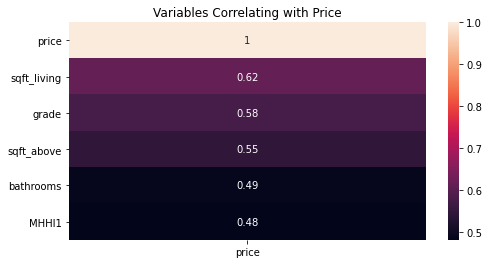

In [178]:
# df_clean_cor = df_clean[['price','sqft_living','grade','sqft_above','bathrooms','MHHI1']]
df_corr = abs(correlation(df_clean_cor))
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_corr[['price']].sort_values(by='price',ascending=False), annot=True)

ax.set_title('Variables Correlating with Price')
# plt.savefig('Group_plots/correlation_plot.png', dpi=100)

<AxesSubplot:>

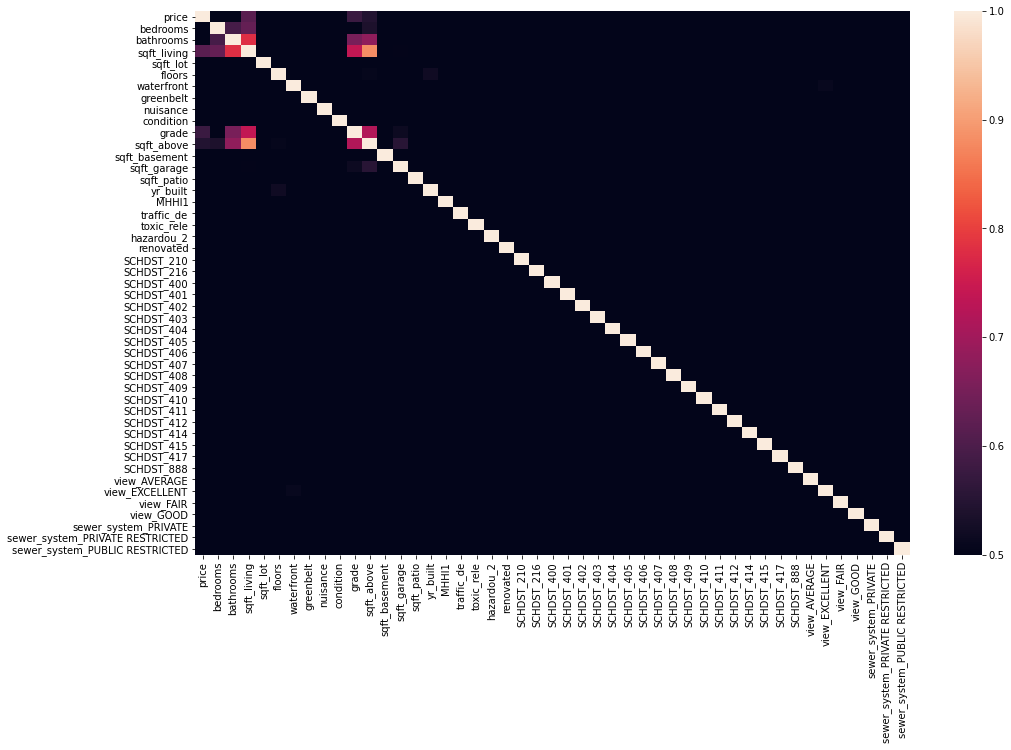

In [30]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(abs(df_clean.corr()), annot=False,ax=ax,vmin=.5)

<AxesSubplot:>

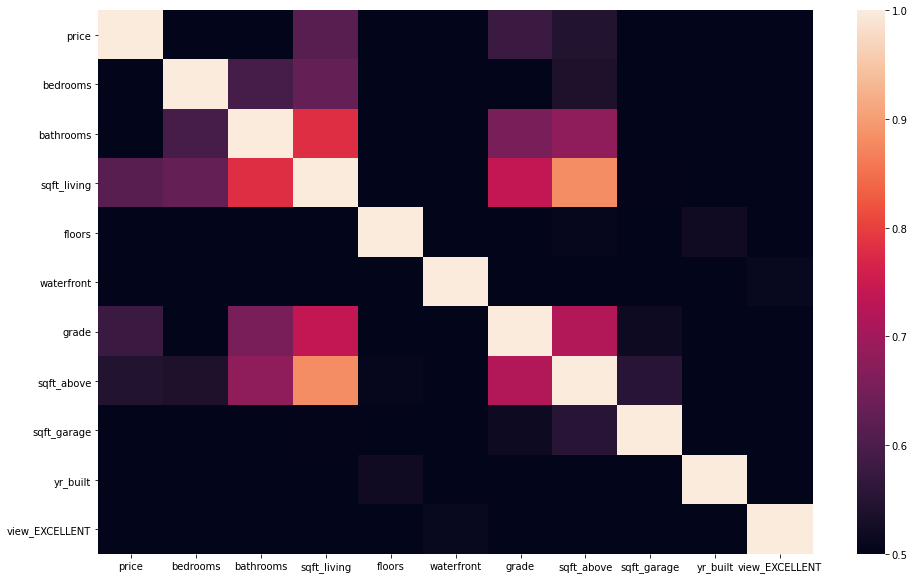

In [31]:
df_cc = abs(df_clean.corr())
threshold = (df_cc > .5) & (df_cc < 1)
df_ccf = df_cc.loc[threshold.any(axis=1),threshold.any(axis=0)]
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_ccf, annot=False,ax=ax,vmin=.5)

In [32]:
# stack creates a series of tuples
filters = df_ccf[threshold].stack()

# sorts each tuple so any xy and yx will now all be xy and xy
# when using sorted each variable becomes a list so they need to be converted back to a tuple
#lastly now peform a set on the tuples
filtered = set(tuple(sorted(l,reverse=True)) for l in list(filters.index))
# for f in filtered:
print(f'Highley correlating variables:\n')
list(map(print, sorted(filtered)));

Highley correlating variables:

('bedrooms', 'bathrooms')
('grade', 'bathrooms')
('price', 'grade')
('sqft_above', 'bathrooms')
('sqft_above', 'bedrooms')
('sqft_above', 'floors')
('sqft_above', 'grade')
('sqft_above', 'price')
('sqft_garage', 'grade')
('sqft_garage', 'sqft_above')
('sqft_living', 'bathrooms')
('sqft_living', 'bedrooms')
('sqft_living', 'grade')
('sqft_living', 'price')
('sqft_living', 'sqft_above')
('sqft_living', 'sqft_garage')
('waterfront', 'view_EXCELLENT')
('yr_built', 'floors')


sqft living & Bathrooms


# Creating Regression Models

In [33]:
list(df_clean.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'greenbelt',
 'nuisance',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'MHHI1',
 'traffic_de',
 'toxic_rele',
 'hazardou_2',
 'renovated',
 'SCHDST_210',
 'SCHDST_216',
 'SCHDST_400',
 'SCHDST_401',
 'SCHDST_402',
 'SCHDST_403',
 'SCHDST_404',
 'SCHDST_405',
 'SCHDST_406',
 'SCHDST_407',
 'SCHDST_408',
 'SCHDST_409',
 'SCHDST_410',
 'SCHDST_411',
 'SCHDST_412',
 'SCHDST_414',
 'SCHDST_415',
 'SCHDST_417',
 'SCHDST_888',
 'view_AVERAGE',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'sewer_system_PRIVATE',
 'sewer_system_PRIVATE RESTRICTED',
 'sewer_system_PUBLIC RESTRICTED']

In [34]:
def mlr(df,column,model_t=None, simple=False):
    '''
    This runs a Multiple Linear Regression for a set list from df_numeric.
    Call an int to return the list of columns used, mlr(1)
    dataframe,y column, optional single regression add column
    simple: 
    True = simple
    False = multiple
    model_t:
    'x' = return x columns used
    'fit' = no summary
    '''
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types\n{df_object.columns}')
    df1 = df.drop(df_object,axis=1)

    
    if simple == True:
        highest_corr = correlation(df, column).abs().idxmax()
        x = df[highest_corr]
    elif simple == False:
        x = df1.drop(column, axis=1)
        
    # Define the y variables
    y = df1[column]
    # create model
    model = sm.OLS(y,sm.add_constant(x)).fit()

    if model_t == 'x':
        return(sm.add_constant(x))
    elif model_t == 'fit':
        return(model)
    
    # Model Summary
    return(model.summary())


In [35]:
mlr(df_clean,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:54:25   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.713e+06   3.34e+05      5.122      0.000    1.06e+06    2.37e+06
bedrooms                        -8.002e+04   4557.539    -17.559      0.000    -8.9e+04   -7.11e+04
bathrooms                        6.272e+04   6644.323      9.440      0.000    4.97e+04    7.57e+04
sqft_living                       130.3690     15.107      8.630      0.000     100.759     159.979
sqft_lot                            0.5480      0.058      9.414      0.000       0.434       0.662
floors                           -1.09e+05   8955.114    -12.169      0.000   -1.27e+05   -9.14e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
condition                         3.85e+04   5134.611      7.498      0.000    2.84e+04    4.86e+04
grade                            1.199e+05   5116.019     23.427      0.000     1.1e+05     1.3e+05
sqft_above                        303.3486     15.360     19.749      0.000     273.243     333.455
sqft_basement                      91.9130     11.490      8.000      0.000      69.393     114.433
sqft_garage                      -104.0133     16.488     -6.308      0.000    -136.331     -71.695
sqft_patio                         89.8445     15.019      5.982      0.000      60.407     119.281
yr_built                        -1174.2747    174.287     -6.738      0.000   -1515.886    -832.663
MHHI1                               3.9124      0.150     26.154      0.000       3.619       4.206
traffic_de                       1.225e+04   1368.593      8.948      0.000    9563.251    1.49e+04
toxic_rele                         -0.3712      0.144     -2.575      0.010      -0.654      -0.089
hazardou_2                       -3.08e+04   2977.798    -10.344      0.000   -3.66e+04    -2.5e+04
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

# Testing Scaling Numerical Variables

In [135]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Instanstiate SS from sklearn
ss = StandardScaler()

In [194]:
len(df_clean.columns)

47

In [186]:
df_scale_1 = df_clean.copy()
# seperate dummies and non-dummies, also drop out boolean values 'waterfront','greenbelt', 'nuisance'
scale_columns = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','condition','grade','sqft_above',
                 'sqft_basement','sqft_garage','sqft_patio',
                'yr_built','MHHI1','toxic_rele','hazardou_2','traffic_de']
df_scale = df_scale_1[scale_columns]
df_dum = df_scale_1.drop(columns=scale_columns)
# Fit on data 
ss.fit(df_scale)

StandardScaler()

In [187]:
len(scale_columns)

16

In [188]:
ss.mean_

array([3.43671580e+00, 2.33256771e+00, 2.13129681e+03, 1.71240494e+04,
       1.51648954e+00, 2.48735002e+00, 7.63873843e+00, 1.82611409e+03,
       4.81217689e+02, 3.36572369e+02, 2.16338258e+02, 1.97384227e+03,
       8.97680184e+04, 1.80221169e+04, 5.44010970e+00, 5.07915667e+00])

In [189]:
ss.scale_

array([9.76685315e-01, 8.94384275e-01, 9.76622269e+02, 6.08290520e+04,
       5.48272086e-01, 7.07902215e-01, 1.15240765e+00, 8.80068842e+02,
       5.86123186e+02, 2.86177674e+02, 2.46752100e+02, 3.16546756e+01,
       3.07862773e+04, 2.82299814e+04, 2.84382588e+00, 2.68495617e+00])

In [190]:
# Transform data
array_sc = ss.transform(df_scale)
df_sc = pd.DataFrame(array_sc, columns=df_scale.columns, index= list(df_scale.index))

**Joining scaled dataframe to dummies df**

In [191]:
df_full_sc = pd.concat([df_sc, df_dum], axis=1)
df_full_sc

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,...,SCHDST_415,SCHDST_417,SCHDST_888,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC RESTRICTED
0,0.576730,-1.489927,-0.974068,-0.164133,-0.942031,0.724182,-0.554264,-0.734163,-0.821018,-1.176096,...,0,0,0,0,0,0,0,0,0,0
1,0.576730,-0.371840,0.039630,-0.157886,-0.942031,-0.688443,-0.554264,-0.665987,1.294578,0.536127,...,0,0,0,0,0,0,0,0,0,0
2,-0.447141,-0.371840,-0.625930,-0.145885,-0.942031,-0.688443,0.313484,-0.722800,0.185596,0.291524,...,0,0,0,0,0,0,0,0,0,0
3,-0.447141,0.187204,0.449205,-0.234017,0.881880,-0.688443,0.313484,0.004415,0.441515,0.501184,...,0,0,0,0,0,0,0,0,0,0
4,-0.447141,0.187204,-0.533775,-0.139720,-0.942031,0.724182,0.313484,-0.756889,0.185596,0.361411,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,-1.471012,-1.489927,-1.363165,-0.118316,-0.030075,-0.688443,-3.157510,-1.165948,-0.821018,-1.176096,...,0,0,0,0,0,0,0,1,0,0
29166,-1.471012,-1.489927,-1.004786,-0.115505,-0.030075,-0.688443,-1.422013,-0.768251,-0.821018,-1.176096,...,0,0,0,1,0,0,0,1,0,0
29167,-2.494883,-1.489927,-1.547473,-0.110540,-0.030075,-0.688443,-1.422013,-1.370477,-0.821018,-1.176096,...,0,0,0,0,0,0,0,1,0,0
29168,-1.471012,-0.930884,-1.178856,-0.199313,0.881880,-0.688443,-0.554264,-0.961418,-0.821018,-1.176096,...,0,0,0,0,0,0,0,0,0,0


In [141]:
mlr(df_clean,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:10:58   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.713e+06   3.34e+05      5.122      0.000    1.06e+06    2.37e+06
bedrooms                        -8.002e+04   4557.539    -17.559      0.000    -8.9e+04   -7.11e+04
bathrooms                        6.272e+04   6644.323      9.440      0.000    4.97e+04    7.57e+04
sqft_living                       130.3690     15.107      8.630      0.000     100.759     159.979
sqft_lot                            0.5480      0.058      9.414      0.000       0.434       0.662
floors                           -1.09e+05   8955.114    -12.169      0.000   -1.27e+05   -9.14e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
condition                         3.85e+04   5134.611      7.498      0.000    2.84e+04    4.86e+04
grade                            1.199e+05   5116.019     23.427      0.000     1.1e+05     1.3e+05
sqft_above                        303.3486     15.360     19.749      0.000     273.243     333.455
sqft_basement                      91.9130     11.490      8.000      0.000      69.393     114.433
sqft_garage                      -104.0133     16.488     -6.308      0.000    -136.331     -71.695
sqft_patio                         89.8445     15.019      5.982      0.000      60.407     119.281
yr_built                        -1174.2747    174.287     -6.738      0.000   -1515.886    -832.663
MHHI1                               3.9124      0.150     26.154      0.000       3.619       4.206
traffic_de                       1.225e+04   1368.593      8.948      0.000    9563.251    1.49e+04
toxic_rele                         -0.3712      0.144     -2.575      0.010      -0.654      -0.089
hazardou_2                       -3.08e+04   2977.798    -10.344      0.000   -3.66e+04    -2.5e+04
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

In [183]:
df_clean['waterfront'].value_counts()

0    28664
1      506
Name: waterfront, dtype: int64

In [196]:
mlr(df_full_sc,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:05:23   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.221e+06   8545.901    142.887      0.000     1.2e+06    1.24e+06
bedrooms                        -7.816e+04   4451.281    -17.559      0.000   -8.69e+04   -6.94e+04
bathrooms                         5.61e+04   5942.578      9.440      0.000    4.44e+04    6.77e+04
sqft_living                      1.273e+05   1.48e+04      8.630      0.000    9.84e+04    1.56e+05
sqft_lot                         3.334e+04   3541.355      9.414      0.000    2.64e+04    4.03e+04
floors                          -5.975e+04   4909.839    -12.169      0.000   -6.94e+04   -5.01e+04
condition                        2.725e+04   3634.802      7.498      0.000    2.01e+04    3.44e+04
grade                            1.381e+05   5895.740     23.427      0.000    1.27e+05     1.5e+05
sqft_above                        2.67e+05   1.35e+04     19.749      0.000     2.4e+05    2.93e+05
sqft_basement                    5.387e+04   6734.274      8.000      0.000    4.07e+04    6.71e+04
sqft_garage                     -2.977e+04   4718.613     -6.308      0.000    -3.9e+04   -2.05e+04
sqft_patio                       2.217e+04   3705.854      5.982      0.000    1.49e+04    2.94e+04
yr_built                        -3.717e+04   5517.011     -6.738      0.000    -4.8e+04   -2.64e+04
MHHI1                            1.204e+05   4605.225     26.154      0.000    1.11e+05    1.29e+05
toxic_rele                      -1.048e+04   4070.194     -2.575      0.010   -1.85e+04   -2501.057
hazardou_2                       -8.76e+04   8468.340    -10.344      0.000   -1.04e+05    -7.1e+04
traffic_de                       3.288e+04   3674.611      8.948      0.000    2.57e+04    4.01e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

In [45]:
mlr(df_clean5,'price')

NameError: name 'df_clean5' is not defined

# Testing the VIFs
- Use to gauge how much the error around the beta for a particular variable is increased because of multicollinearity

In [199]:
def vif(df,column):
    '''
    Test for VIFs
    input: Dataframe
    '''
    vif_model = mlr(df,column,'fit')
    vif_table = 1 / (1-vif_model.rsquared)
    
    print(f'VIF value: {vif_table}')

In [200]:
clean_vif = vif(df_clean,'price')

The following columns were dropped due to being object types
Index([], dtype='object')
VIF value: 2.6645678075003802


In [201]:
scale_vif = vif(df_full_sc,'price')

The following columns were dropped due to being object types
Index([], dtype='object')
VIF value: 3.2436478198763545


In [49]:
model_sklr = LinearRegression().fit(df_clean, df_clean['price'])
model_sklr.score(df_clean, df_clean['price'])

1.0

In [50]:
model_sklr = LinearRegression().fit(df_full_sc, df_full_sc['price'])
model_sklr.score(df_full_sc, df_full_sc['price'])

1.0

## Simple Model

In [51]:
mlr(df_clean,'price',simple=True)

The following columns were dropped due to being object types
Index([], dtype='object')
The following columns were dropped due to being object types
Index([], dtype='object')
Correlation to price


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:54:50   Log-Likelihood:            -4.3419e+05
No. Observations:               29170   AIC:                         8.684e+05
Df Residuals:                   29168   BIC:                         8.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.221e+04   9908.686     -9.306      0.000   -1.12e+05   -7.28e+04
sqft_living   565.3827      4.227    133.770      0.000     557.099     573.667
==============================================================================
Omnibus:                    42232.632   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50100657.663
Skew:                           8.242   Prob(JB):                         0.00
Kurtosis:                     205.359   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
mlr(df_full_sc,'price',simple=True)

The following columns were dropped due to being object types
Index([], dtype='object')
The following columns were dropped due to being object types
Index([], dtype='object')
Correlation to price


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:54:52   Log-Likelihood:            -4.3419e+05
No. Observations:               29170   AIC:                         8.684e+05
Df Residuals:                   29168   BIC:                         8.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.113e+06   4127.725    269.589      0.000     1.1e+06    1.12e+06
sqft_living  5.522e+05   4127.725    133.770      0.000    5.44e+05     5.6e+05
==============================================================================
Omnibus:                    42232.632   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50100657.663
Skew:                           8.242   Prob(JB):                         0.00
Kurtosis:                     205.359   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
remove = ['toxic_rele','MHHI1']
df_clean_test = df_clean.drop(columns=remove)

In [54]:
mlr(df_clean_test,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     1059.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:54:59   Log-Likelihood:            -4.2723e+05
No. Observations:               29170   AIC:                         8.545e+05
Df Residuals:                   29125   BIC:                         8.549e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            2.861e+06   3.36e+05      8.525      0.000     2.2e+06    3.52e+06
bedrooms                        -8.612e+04   4606.863    -18.694      0.000   -9.52e+04   -7.71e+04
bathrooms                        6.482e+04   6724.894      9.639      0.000    5.16e+04     7.8e+04
sqft_living                       138.5376     15.288      9.062      0.000     108.572     168.503
sqft_lot                            0.5253      0.059      8.916      0.000       0.410       0.641
floors                          -1.067e+05   9061.810    -11.776      0.000   -1.24e+05    -8.9e+04
waterfront                       8.161e+05   3.01e+04     27.119      0.000    7.57e+05    8.75e+05
greenbelt                       -4.584e+04    2.1e+04     -2.183      0.029    -8.7e+04   -4683.156
nuisance                        -2.017e+04   8924.808     -2.260      0.024   -3.77e+04   -2676.204
condition                        3.938e+04   5196.980      7.578      0.000    2.92e+04    4.96e+04
grade                            1.407e+05   5117.805     27.498      0.000    1.31e+05    1.51e+05
sqft_above                        308.5304     15.546     19.846      0.000     278.059     339.002
sqft_basement                      93.3005     11.630      8.022      0.000      70.505     116.096
sqft_garage                       -96.8327     16.685     -5.804      0.000    -129.536     -64.130
sqft_patio                         82.5884     15.198      5.434      0.000      52.799     112.378
yr_built                        -1606.2708    175.535     -9.151      0.000   -1950.328   -1262.214
traffic_de                       1833.6827   1326.081      1.383      0.167    -765.497    4432.862
hazardou_2                      -5.242e+04   2768.400    -18.934      0.000   -5.78e+04    -4.7e+04
renovated                        6.304e+04   1.67e+04      3.781      0.000    3.04e+04    9.57e+04
SCHDST_210                      -2.945e+05      2e+04    -14.721      0.000   -3.34e+05   -2.55e+05
SCHDST_216                      -6.325e+05   2.42e+04    -26.151      0.000    -6.8e+05   -5.85e+05
SCHDST_400                       8.179e+05   3.19e+04     25.654      0.000    7.55e+05     8.8e+05
SCHDST_401                      -1.643e+05   1.87e+04     -8.806      0.000   -2.01e+05   -1.28e+05
SCHDST_402                      -3.773e+05   4.29e+04     -8.792      0.000   -4.61e+05   -2.93e+05
SCHDST_403                       -1.01e+05   1.93e+04     -5.230      0.000   -1.39e+05   -6.31e+04
SCHDST_404                      -6.598e+05    1.2e+05     -5.506      0.000   -8.95e+05   -4.25e+05
SCHDST_405                       6.581e+05   1.73e+04     38.049      0.000    6.24e+05    6.92e+05
SCHDST_406                      -1.176e+05    4.8e+04     -2.449      0.014   -2.12

There is a significantly high multicollinearity between variables

# Checking Assumptions

# Model 5

Defining x, y, and the model variables

In [115]:
df_clean_5 = df_clean.copy()
df_clean5 = df_clean_5.drop(columns=['greenbelt','sqft_garage'])
df_clean5['sqft_living'] = np.log(df_clean5['sqft_living'])
df_clean5['price'] = np.log(df_clean5['price'])


In [116]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2', 'renovated',
       'SCHDST_210', 'SCHDST_216', 'SCHDST_400', 'SCHDST_401', 'SCHDST_402',
       'SCHDST_403', 'SCHDST_404', 'SCHDST_405', 'SCHDST_406', 'SCHDST_407',
       'SCHDST_408', 'SCHDST_409', 'SCHDST_410', 'SCHDST_411', 'SCHDST_412',
       'SCHDST_414', 'SCHDST_415', 'SCHDST_417', 'SCHDST_888', 'view_AVERAGE',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'sewer_system_PRIVATE',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED'],
      dtype='object')

In [197]:
# model

df_full_sc['price'] = np.log(df_full_sc['price'])
model_mlr = mlr(df_full_sc,'price', 'fit',False)
# X constant
X = mlr(df_full_sc,'price','x',False)
# y 
Y = df_full_sc['price']

# # model
# model_mlr = mlr(df_clean5,'price', 'fit',False)
# # X constant
# X = mlr(df_clean5,'price','x',False)
# # y 
# Y = df_clean5['price']

The following columns were dropped due to being object types
Index([], dtype='object')
The following columns were dropped due to being object types
Index([], dtype='object')


## 1. Linearity and Homoskedasticity

Slope: 5.306607745174461e-17
Intercept: -1.924710843354276e-14
Correlation: (r) 7.948667499998065e-17


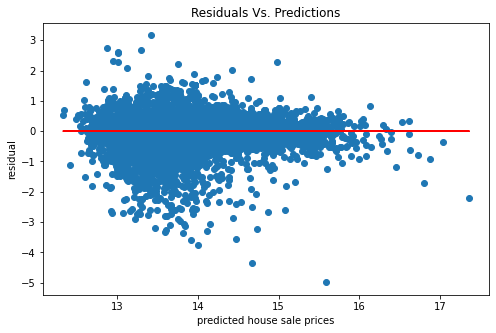

In [198]:

# calculating resid method 1
# model_L = model_mlr.predict(X)
# resid = Y - model_L
# x_res = model_L
# y_res = resid

# calculating resid method 2
resid = model_mlr.resid
x_res = model_mlr.predict()


fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x_res, resid)

slope, intercept, r, p, se = linregress(x_res,resid)
lin_r = linregress(x_res, resid)
plt.plot(x_res, lin_r.intercept + lin_r.slope*x_res, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('predicted house sale prices')
ax.set_ylabel('residual')
ax.set_title('Residuals Vs. Predictions');

# 2. Independence
Checking if errors are independent
- Create scatter plot of residuals and target values
    - Evaluete and identify patterns
- Check Durbin-Watson Statistic

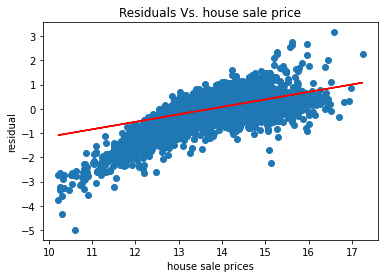

In [148]:
fig, ax = plt.subplots()
ax.scatter(Y, resid)

slope, intercept, r, p, se = linregress(Y,resid)
lin_r = linregress(Y, resid)
plt.plot(Y, lin_r.intercept + lin_r.slope*Y, 'r')

ax.set_xlabel('house sale prices')
ax.set_ylabel('residual')
ax.set_title('Residuals Vs. house sale price');

- Upward trend in this scatter plot indicates positive correlation in the errors

### Durbin-Watson
- Checks for autocorrelation in the residuals.
- Autocorrelation occurs when residuals are not independent.
- The range is from 0-4 
- values close to 2 indcate no significant autocorrelation (1.5 - 2.5)
- Values below 2 indicate positive autocorrelation
- Values above 2 indicate negative autocorrelation

In [124]:
dw = sm.stats.stattools.durbin_watson
dw(resid)

1.7920756796178703

Our autocorrelation from the Durbin-Watson test indicates a little to no signifcant autocorrelation

Possible positive auto correlation

In [125]:
model_mlr.summary().tables[2]

Omnibus:,17356.536,Durbin-Watson:,1.792
Prob(Omnibus):,0.000,Jarque-Bera (JB):,580710.869
Skew:,-2.308,Prob(JB):,0.00
Kurtosis:,24.366,Cond. No.,273.


## 3. Normality

### Histograms

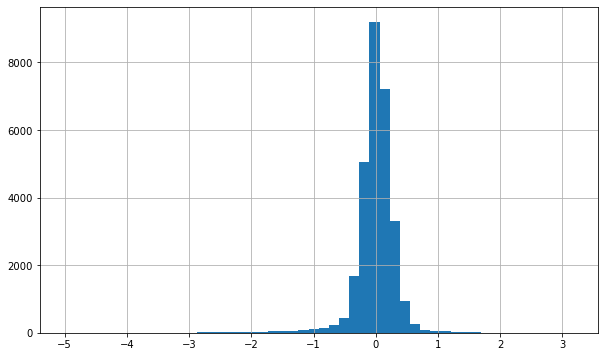

In [126]:
resid.hist(bins=50,figsize=(10,6));

Resizing the histogram to remove outliers

In [127]:
# resid[abs(resid) < 2500000].hist(bins=50,figsize=(10,6));

### QQ Plot

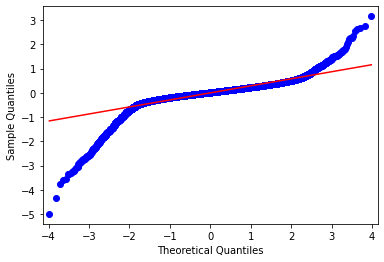

In [128]:
sm.qqplot(resid, line='r');

Slope: 0.8979518844416661
Intercept: 156263.90566511697
Correlation: (r) 0.8040230998415224


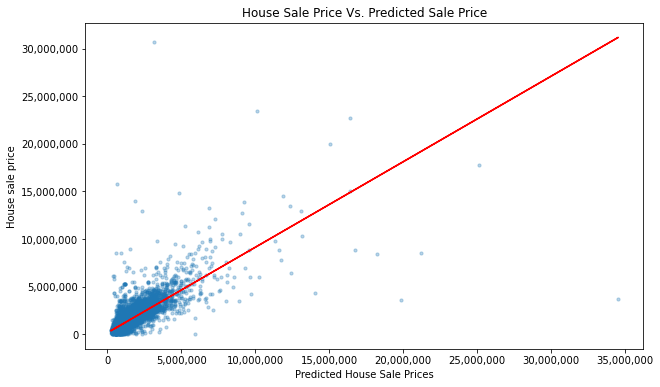

In [160]:
from matplotlib.ticker import StrMethodFormatter, FuncFormatter

fig, ax = plt.subplots(figsize=(10,6))


x_pre = np.exp(model_mlr.predict(X))
y_pre = np.exp(Y)


# x_pre = model_mlr.predict(X)
# y_pre = Y



ax.scatter(x_pre, y_pre,s=10,alpha=.3)

# Removing scientific notation
ax.ticklabel_format(useOffset=False, style='plain')

# Set the major formatter and use fstring notation to adjust the axes
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

slope, intercept, r, p, se = linregress(x_pre,y_pre)
lin_r = linregress(x_pre, y_pre)
plt.plot(x_pre, lin_r.intercept + lin_r.slope*x_pre, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('Predicted House Sale Prices')
ax.set_ylabel('House sale price')
ax.set_title('House Sale Price Vs. Predicted Sale Price');
# plt.savefig('Group_plots/saleprice_predictedprice.png', dpi=100)

Slope: 565.382728013178
Intercept: -92211.21803300874
Correlation: (r) 0.6166254384510194


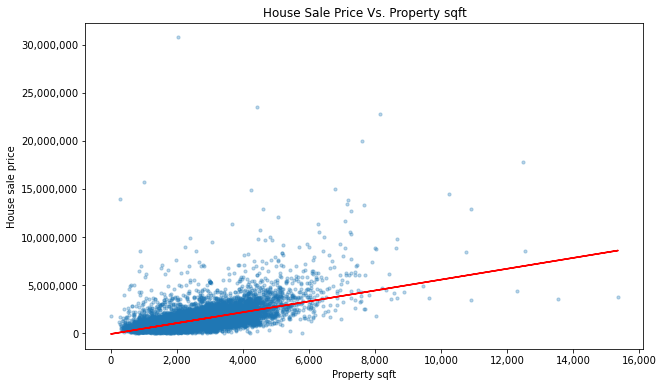

In [182]:
from matplotlib.ticker import StrMethodFormatter, FuncFormatter

fig, ax = plt.subplots(figsize=(10,6))

x_sq = df_clean['sqft_living']
y_p = df_clean['price']
ax.scatter(x_sq, y_p,s=10,alpha=.3)

# Removing scientific notation
ax.ticklabel_format(useOffset=False, style='plain')

# Set the major formatter and use fstring notation to adjust the axes
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

slope, intercept, r, p, se = linregress(x_sq, y_p)
lin_r = linregress(x_sq, y_p)
plt.plot(x_sq, lin_r.intercept + lin_r.slope*x_sq, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('Property sqft')
ax.set_ylabel('House sale price')
ax.set_title('House Sale Price Vs. Property sqft');
# plt.savefig('Group_plots/sqft_price.png', dpi=100)

In [131]:
model_mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1420.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:06:47   Log-Likelihood:                -8604.6
No. Observations:               29170   AIC:                         1.730e+04
Df Residuals:                   29123   BIC:                         1.769e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              13.8680      0.005   2739.165      0.000      13.858      13.878
bedrooms                            0.0046      0.003      1.750      0.080      -0.001       0.010
bathrooms                           0.0333      0.004      9.450      0.000       0.026       0.040
sqft_living                         0.0775      0.009      8.870      0.000       0.060       0.095
sqft_lot                            0.0299      0.002     14.254      0.000       0.026       0.034
floors                             -0.0049      0.003     -1.683      0.092      -0.011       0.001
condition                           0.0411      0.002     19.101      0.000       0.037       0.045
grade                               0.1124      0.003     32.177      0.000       0.106       0.119
sqft_above                          0.1048      0.008     13.081      0.000       0.089       0.120
sqft_basement                       0.0201      0.004      5.047      0.000       0.012       0.028
sqft_garage                         0.0024      0.003      0.864      0.388      -0.003       0.008
sqft_patio                          0.0109      0.002      4.943      0.000       0.007       0.015
yr_built                           -0.0211      0.003     -6.469      0.000      -0.028      -0.015
MHHI1                               0.0728      0.003     26.668      0.000       0.067       0.078
traffic_de                         -0.0041      0.002     -1.862      0.063      -0.008       0.000
toxic_rele                         -0.0303      0.002    -12.554      0.000      -0.035      -0.026
hazardou_2                         -0.0826      0.005    -16.468      0.000      -0.092      -0.073
waterfront                          0.2433      0.018     13.811      0.000       0.209       0.278
greenbelt                           0.0006      0.012      0.045      0.964      -0.024       0.025
nuisance                           -0.0348      0.005     -6.670      0.000      -0.045      -0.025
renovated                           0.0703      0.010      7.201      0.000       0.051       0.089
SCHDST_210                         -0.4044      0.013    -31.769      0.000      -0.429      -0.379
SCHDST_216                         -0.5630      0.014    -39.079      0.000      -0.591      -0.535
SCHDST_400                          0.2449      0.020     12.549      0.000       0.207       0.283
SCHDST_401                         -0.2522      0.011    -22.174      0.000      -0.275      -0.230
SCHDST_402                         -0.1538      0.026     -6.025      0.000      -0.204      -0.104
SCHDST_403                         -0.1860      0.012    -15.636      0.000      -0.209      -0.163
SCHDST_404                         -0.8854      0.070    -12.623      0.000      -1

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean squared error
mse = mean_squared_error(x_pre,y_pre)
print("Mean Squared Error (MSE):", mse)

# Mean absolute error
mae = mean_absolute_error(x_pre,y_pre)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 300932205713.73456
Mean Absolute Error (MAE): 279759.6670544281


Mean Absolute Error (MAE): 230535.5375599474


# Transformations

In [152]:
def kde_plot(xy,x_label,legends=False):
    '''
    xy: Y or X
    x_label: str name for Y or X
    legends: set to True, to show
    Example for what x or y would look like:
    y = df['column']
    x = df[['column1','columns2','column3']]
    
    Example: kde_plot(Y,'price') where Y= df['price']

    '''
    name = str(xy)
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.kdeplot(data=xy,legend=legends, ax=ax)
    plt.title(f'KDE plot of {x_label}')
    plt.xlabel(x_label)
    plt.ylabel('Density')

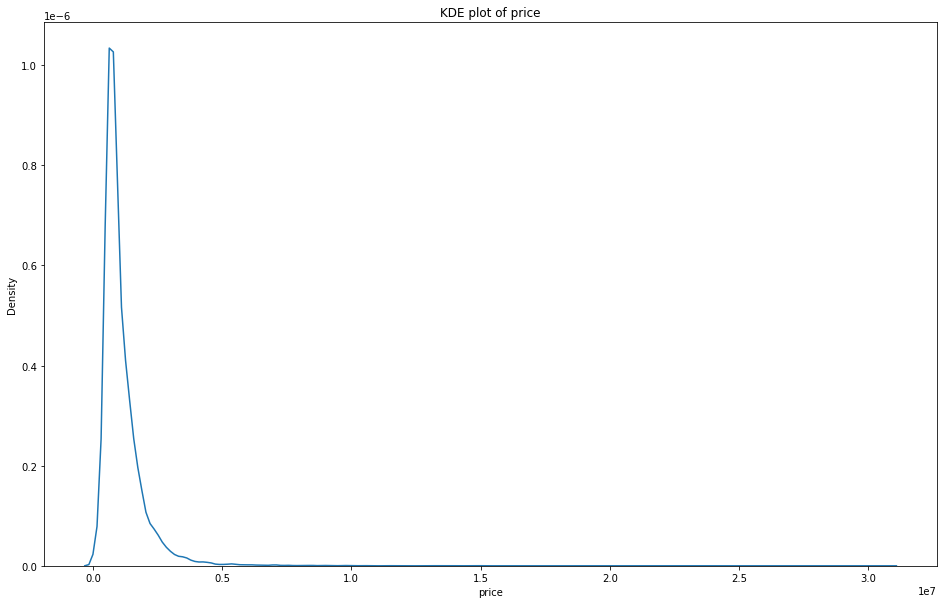

In [157]:
kde_plot(Y,'price')

In [ ]:
x_tester = df_clean[['bathrooms','bedrooms']]
kde_plot(x_tester,'variables',True)

### Checking Distribution of Price

<AxesSubplot:>

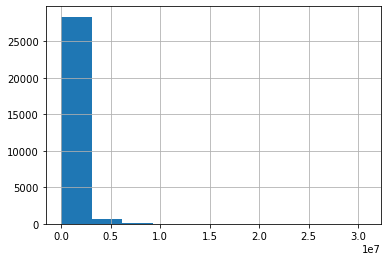

In [517]:
df_clean['price'].hist()

<AxesSubplot:>

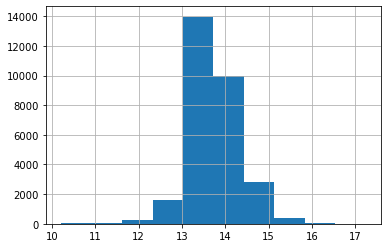

In [518]:
x_logged = np.log(df_clean['price'])
x_logged.hist()

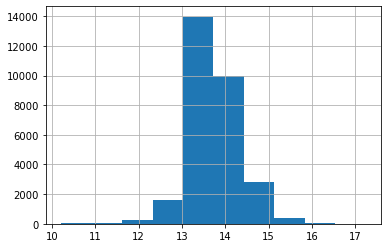

In [519]:
Y.hist();

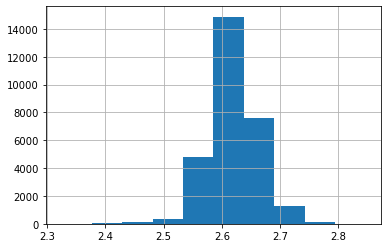

In [520]:
y_scld = np.log(Y)
y_scld.hist();

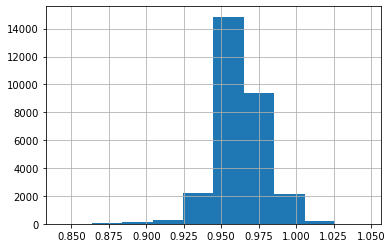

In [521]:
y_scld2 = np.log(y_scld)
y_scld2.hist();

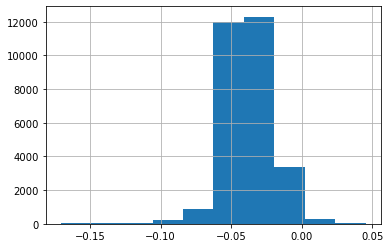

In [522]:
y_scld3 = np.log(y_scld2)
y_scld3.hist();

# Model 3

In [523]:
df_clean3 = df_full_sc.copy()
# df_clean3['sqft_living'] = np.log(df_clean3['sqft_living'])
# df_clean3['price'] = np.log(df_clean3['price'])
# remove3 = ['toxic_rele','sqft_above','sqft_lot','sqft_basement', 'sqft_garage', 'sqft_patio','MHHI1']
# df_clean3 = df_clean3.drop(columns=remove3)
model_clean3 = mlr(df_clean3,'price')
model_clean3

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     932.8
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:29:03   Log-Likelihood:                -27089.
No. Observations:               29170   AIC:                         5.428e+04
Df Residuals:                   29117   BIC:                         5.472e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.1146      0.010     11.371      0.000       0.095       0.134
bedrooms                           -0.0865      0.005    -17.376      0.000      -0.096      -0.077
bathrooms                           0.0615      0.007      9.214      0.000       0.048       0.075
sqft_living                         0.1404      0.017      8.503      0.000       0.108       0.173
sqft_lot                            0.0367      0.004      9.250      0.000       0.029       0.044
floors                             -0.0669      0.005    -12.172      0.000      -0.078      -0.056
condition                           0.0295      0.004      7.215      0.000       0.022       0.038
grade                               0.1559      0.007     23.606      0.000       0.143       0.169
sqft_above                          0.3015      0.015     19.868      0.000       0.272       0.331
sqft_basement                       0.0617      0.008      8.156      0.000       0.047       0.077
sqft_garage                        -0.0322      0.005     -6.093      0.000      -0.043      -0.022
sqft_patio                          0.0238      0.004      5.744      0.000       0.016       0.032
yr_built                           -0.0445      0.006     -7.134      0.000      -0.057      -0.032
MHHI1                               0.1345      0.005     26.159      0.000       0.124       0.145
traffic_de                          0.0365      0.004      8.901      0.000       0.028       0.045
toxic_rele                         -0.0123      0.005     -2.707      0.007      -0.021      -0.003
hazardou_2                         -0.0975      0.009    -10.314      0.000      -0.116      -0.079
waterfront                          0.9076      0.033     27.313      0.000       0.842       0.973
greenbelt                          -0.0787      0.023     -3.395      0.001      -0.124      -0.033
nuisance                           -0.0243      0.010     -2.465      0.014      -0.044      -0.005
renovated                           0.0718      0.018      3.883      0.000       0.036       0.108
SCHDST_210                         -0.3935      0.024    -16.331      0.000      -0.441      -0.346
SCHDST_216                         -0.6247      0.027    -22.965      0.000      -0.678      -0.571
SCHDST_400                          0.6308      0.037     17.143      0.000       0.559       0.703
SCHDST_401                         -0.1816      0.021     -8.468      0.000      -0.224      -0.140
SCHDST_402                         -0.3653      0.048     -7.585      0.000      -0.460      -0.271
SCHDST_403                         -0.1955      0.022     -8.699      0.000      -0.240      -0.151
SCHDST_404                         -0.7102      0.132     -5.366      0.000      -0

In [490]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2', 'renovated',
       'SCHDST_210', 'SCHDST_216', 'SCHDST_400', 'SCHDST_401', 'SCHDST_402',
       'SCHDST_403', 'SCHDST_404', 'SCHDST_405', 'SCHDST_406', 'SCHDST_407',
       'SCHDST_408', 'SCHDST_409', 'SCHDST_410', 'SCHDST_411', 'SCHDST_412',
       'SCHDST_414', 'SCHDST_415', 'SCHDST_417', 'SCHDST_888', 'view_AVERAGE',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'sewer_system_PRIVATE',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED'],
      dtype='object')

# Model 4
In this model We drop all the years renovated from model 3

In [525]:
df_clean4 = df_full_sc.copy()
# df_clean4['sqft_living'] = np.log(df_clean4['sqft_living'])
# df_clean4['price'] = np.log(df_clean4['price'])
remove4 = ['greenbelt','sqft_garage','sqft_above', 'sqft_basement', 'sqft_patio']
df_clean4 = df_clean4.drop(columns=remove4)
model_clean4 = mlr(df_clean4,'price')
model_clean4

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1002.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:31:16   Log-Likelihood:                -27361.
No. Observations:               29170   AIC:                         5.482e+04
Df Residuals:                   29122   BIC:                         5.522e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0832      0.010      8.533      0.000       0.064       0.102
bedrooms                           -0.0881      0.005    -17.565      0.000      -0.098      -0.078
bathrooms                           0.0445      0.007      6.715      0.000       0.032       0.058
sqft_living                         0.4072      0.008     52.870      0.000       0.392       0.422
sqft_lot                            0.0410      0.004     10.273      0.000       0.033       0.049
floors                             -0.0169      0.005     -3.454      0.001      -0.026      -0.007
condition                           0.0188      0.004      4.625      0.000       0.011       0.027
grade                               0.1725      0.006     26.658      0.000       0.160       0.185
yr_built                           -0.0681      0.006    -11.278      0.000      -0.080      -0.056
MHHI1                               0.1351      0.005     26.058      0.000       0.125       0.145
traffic_de                          0.0374      0.004      9.044      0.000       0.029       0.046
toxic_rele                         -0.0114      0.005     -2.475      0.013      -0.020      -0.002
hazardou_2                         -0.1002      0.010    -10.501      0.000      -0.119      -0.081
waterfront                          0.9240      0.033     27.599      0.000       0.858       0.990
nuisance                           -0.0276      0.010     -2.780      0.005      -0.047      -0.008
renovated                           0.0642      0.019      3.458      0.001       0.028       0.101
SCHDST_210                         -0.3518      0.024    -14.777      0.000      -0.398      -0.305
SCHDST_216                         -0.5518      0.027    -20.538      0.000      -0.604      -0.499
SCHDST_400                          0.6588      0.037     17.841      0.000       0.586       0.731
SCHDST_401                         -0.1487      0.021     -6.945      0.000      -0.191      -0.107
SCHDST_402                         -0.3015      0.048     -6.227      0.000      -0.396      -0.207
SCHDST_403                         -0.1602      0.022     -7.187      0.000      -0.204      -0.116
SCHDST_404                         -0.6744      0.134     -5.050      0.000      -0.936      -0.413
SCHDST_405                          0.6588      0.020     33.540      0.000       0.620       0.697
SCHDST_406                         -0.0880      0.054     -1.644      0.100      -0.193       0.017
SCHDST_407                         -0.5105      0.033    -15.243      0.000      -0.576      -0.445
SCHDST_408                         -0.3760      0.024    -15.979      0.000      -0.422      -0.330
SCHDST_409                         -0.4457      0.024    -18.714      0.000      -0

In [ ]:
df_clean.columns

In [ ]:
cdf = df_clean.copy()

# remove4 = ['lat','long','date','toxic_rele','yr_renovated','sqft_above','sqft_lot','sqft_basement', 
#            'sqft_garage', 'sqft_patio','MHHI1','sqft_living']
# cdf_df = cdf.drop(columns=remove4)


cdf['sqft_living'] = np.log(cdf['sqft_living'])
cdf['yr_built'] = np.log(cdf['yr_built'])
# df_clean_3['price'] = y_scld#np.log(Y)


cdf_df = cdf[['price', 'bedrooms', 'bathrooms','sqft_living',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition',
       'grade', 'traffic_de','yr_built', 'hazardou_2']]
mlr(cdf_df,'price')

# Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
# pf = PolynomialFeatures(degree=3)

# X = wine.drop('quality', axis=1)
# y = wine['quality']

# # Fitting the PolynomialFeatures object
# pf.fit(X)

In [ ]:
X1 = ['floors','MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2']
y1 = df_clean['price']

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].scatter(df_clean[X1[0]], y1)
axs[0].set_xlabel(f'{X1[0]}')
axs[0].set_ylabel('Price ($)')
axs[0].set_title(f'{X1[0]} vs. Price')

axs[1].scatter(df_clean[X1[1]], y1)
axs[1].set_xlabel(f'{X1[1]}')
axs[1].set_ylabel('Price ($)')
axs[1].set_title(f'{X1[1]} vs. Price')

axs[2].scatter(df_clean[X[2]], y1)
axs[2].set_xlabel(f'{X1[2]}')
axs[2].set_ylabel('Price ($)')
axs[2].set_title(f'{X1[2]} vs. Price')

plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(X,y); 

# ax.set_xlabel('Square Foot Living (ft)')
# ax.set_ylabel('Price ($)')
# ax.set_title('Price of Houses based on Square foot')

# plt.show()

In [ ]:
# sns.lmplot(data=df_cleaned_2, x='sqft_living', y='price')
# plt.xlabel('Sqft Living (sqft)')
# plt.ylabel('Price ($)')
# plt.title('Price against to Sqft Living');